# Hands-On Clasificación de grafos con GNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%202%20-%20Graph%20Neural%20Networks/graph-classification.ipynb)

En este notebook implementaremos un modelo tipo GIN (Graph Isomorphism Network) para una tarea de clasificación de grafos.

#### Referencias
- [Pytorch Geometric - Colab Notebooks and Video Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)
- [Hands-On Graph Neural Networks Using Python](https://www.amazon.com/Hands-Graph-Neural-Networks-Python/dp/1804617520/ref=sr_1_1?crid=3A0QN1RYH7QQP&dib=eyJ2IjoiMSJ9.-qrnI2P8riRrQ4N6OPe1T9dfnkNhYgbD_-VhWVg_MfGU6D4U1TYZdUeJzAAZ1zhM7oyFoU7g3g3DppC-4DGSfmfmBfPUimLKlEKzBnujFTDHedtcSZuiN9EbIyNLxgkYbwfb0Nq4XhQQQZlS4JYFrBs0-rpkS8EmRz1o2OEJ0qrL9EXU9EJuj9cxCWt7J5HFE4nrJJYOPsX9aI78tp1LAEJqdUW14r9RbOYob9JQK0M.wej4dkKelg8wk6GVu5yxbMuiXefgjxhK-E-2n4_dFBs&dib_tag=se&keywords=hands+on+graph+neural+networks+using+python&qid=1713378267&sprefix=handson+gra%2Caps%2C197&sr=8-1)
- [How Powerful are Graph Neural Networks](https://arxiv.org/abs/1810.00826)

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [2]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%202%20-%20Graph%20Neural%20Networks/requirements.txt && pip install -r requirements.txt

In [3]:
if IN_COLAB:
    import torch

    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Functiones utilitarias

Definimos algunas funciones utilitarias simples para observar las características del dataset que estamos usando.

In [4]:
from torch_geometric.data import Dataset
from torch_geometric.data.data import BaseData

def print_dataset_summary(dataset: Dataset):
    print(f'Dataset: {dataset}')
    print(f'=' * 20)
    print(f'Número de grafos: {len(dataset)}')
    print(f'Número de features: {dataset.num_features}')
    print(f'Número de clases: {dataset.num_classes}')


def print_graph_summary(data: BaseData):
    print(f'=' * 50)
    print(f'Número de nodos: {data.num_nodes}')
    print(f'Número de conexiones: {data.num_edges}')
    print(f'Grado promedio: {data.num_edges / data.num_nodes:.2f}')

## TU Dortmund - Protein Dataset

Para este notebook utilizaremos el dataset de proteinas de la universidad técnica de Dortmund. Desde el punto de vista de pytorch geometric, la clase `TUDataset` es realmente un contenedor de muchos otros datasets the grafos en varios campos de aplicación, no solo proteínas. Sin embargo, para este notebook vamos a trabajar exclusivamente con el dataset `PROTEINS`. Según la librería, este dataset está basado en el problema de clasificación de si una proteína cumple una función de enzima o no, en función de su estructura. Entonces estamos hablando de un problema de clasificación binario que busca determinar si una proteina es una enzima o no.


### Referencias
- [TU Dormund University](https://chrsmrrs.github.io/datasets)
- [Protein function prediction via graph kernels](https://academic.oup.com/bioinformatics/article/21/suppl_1/i47/202991)
- [Distinguishing enzyme structures from non-enzymes without alignments](https://pubmed.ncbi.nlm.nih.gov/12850146/)

In [5]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

print_dataset_summary(dataset)
print_graph_summary(dataset[0])


Dataset: PROTEINS(1113)
Número de grafos: 1113
Número de features: 3
Número de clases: 2
Número de nodos: 76
Número de conexiones: 240
Grado promedio: 3.16


Preparamos los respectivos subconjuntos de datos.

In [6]:
train_idx = int(len(dataset) * 0.8)
val_idx = int(len(dataset) * 0.9)

train_dataset = dataset[:train_idx]
val_dataset = dataset[train_idx: val_idx]
test_dataset = dataset[val_idx:]

print(f'Training set: {len(train_dataset)}')
print(f'Validation set: {len(val_dataset)}')
print(f'Testing set: {len(test_dataset)}')

Training set: 890
Validation set: 111
Testing set: 112


Y los dataloaders.

In [7]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Definición del modelo GIN

Recordemos que la definición canónica de los embeddings de un grafo la podemos sintetizar en:

$$
h_i^{\prime} = \phi(h_i, f({h_j: j \in \mathcal{N}_i}))
$$

Donde $\phi$ is la función que combina los embeddings del nodo $i$ con el resultado de la agregación $f$ del vecindario de $i$. Estas funciones de agregación, deberían ser inyectivas. Para el caso de GIN, lo que además se hace es un pooling global al resultante de todas las capas de los embeddings. Según los autores, la suma global entregaría una mejor expresividad que el promedio o el máximo, por lo que aplicaremos un *sum global pooling*:

$$
h_G = \sum_{i=0}^{N}h_i
$$

Finalmente, concatenarémos el resultado de todas las capas intermedias para someterlas a una clasificación lineal:

$$
h_G= \sum_{i=0}^{N}h_i^0 || ...|| \sum_{i=0}^{N}h_i^k
$$


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule, Trainer
from torch_geometric.nn import GINConv, global_add_pool
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy



class GINClassifier(LightningModule):

    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """GINClassifier

        Aquí definimos los tres bloques GIN y el bloque denso.

        Nótese que en el bloque denso multiplicamos por 3 el tamaño
        del embedding. Esto es porque tenemos 3 capas GIN y vamos
        a concatenarlas todas para no perder información. Esto nos
        deja con un embedding interno 3 veces mayor que el hidden_size
        definido.
        """
        super(GINClassifier, self).__init__()
        self.conv1 = GINConv(
            nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            )
        )

        self.conv2 = GINConv(
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            )
        )

        self.conv3 = GINConv(
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU()
            )
        )

        self.linear = nn.Sequential(
            nn.Linear(hidden_size * 3, hidden_size * 3),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size * 3, output_size),
            nn.LogSoftmax(dim=1)
        )

        self.train_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.val_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.test_acc = Accuracy(task='multiclass', num_classes=output_size)
        

    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, batch: torch.Tensor) -> torch.Tensor:
        """
        En el forward pass, simplemente vamos pasando la entrada en cascada por 
        todos los bloques convolucionales que definimos.

        Sin embargo, vamos conservando las activaciones intermedias. Esto nos
        permitirá hacer la concatenación que los autores nos indican. No sin
        antes realizar el global pooling a cada embedding.
        """
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        h = torch.cat((h1, h2, h3), dim=1)

        return self.linear(h)
    

    def training_step(self, batch) -> torch.Tensor:
        """
        El training step is muy estándar y de hecho es más simple que
        el que vimos en la clasificación de nodos. Esto es porque de salida
        obtenemos un único vector de rango 1 (dos dimensiones para las dos clases, 0 y 1)
        Ya no tenemos que discernir por nodos de forma individual.
        """
        x, edge_index, batch_idx, y = batch.x, batch.edge_index, batch.batch, batch.y
        y_hat = self(x, edge_index, batch_idx)
        loss = F.cross_entropy(y_hat, y)
        self.train_acc(y_hat, y)
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    

    def validation_step(self, batch) -> torch.Tensor:
        x, edge_index, batch_idx, y = batch.x, batch.edge_index, batch.batch, batch.y
        y_hat = self(x, edge_index, batch_idx)
        self.val_acc(y_hat, y)
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch) -> torch.Tensor:
        x, edge_index, batch_idx, y = batch.x, batch.edge_index, batch.batch, batch.y
        y_hat = self(x, edge_index, batch_idx)
        self.test_acc(y_hat, y)
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-5)
    

gin_model = GINClassifier(dataset.num_node_features, 32, dataset.num_classes)

tb_logger = TensorBoardLogger('tb_logs', name='GINClassifier')
callbacks=[EarlyStopping(monitor='train-loss', patience=10, mode='min')]
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger, callbacks=callbacks)

trainer.fit(gin_model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | conv1     | GINConv            | 1.2 K 
1 | conv2     | GINConv            | 2.2 K 
2 | conv3     | GINConv            | 2.2 K 
3 | linear    | Sequential         | 9.5 K 
4 | train_acc | MulticlassAccuracy | 0     
5 | val_acc   | MulticlassAccuracy | 0     
6 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.1 K    Trainable params
0         Non-trainable params
15.1 K    Total params
0.060     Total estimated model params size (MB)


Epoch 61: 100%|██████████| 14/14 [00:00<00:00, 80.84it/s, v_num=3, val-acc=0.766, train-loss=0.521, train-acc=0.745] 


Validamos contra el conjunto de prueba.

In [17]:
gin_model.eval()
result = trainer.test(gin_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 150.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.7142857313156128
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Observamos el proceso de entrenamiento.

In [10]:
%load_ext tensorboard

In [12]:
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 25690), started 0:00:10 ago. (Use '!kill 25690' to kill it.)

## Haciendo predicciones

En este caso, como solo tenemos dos clases, lo que vamos a hacer es dibjuar unos cuantos ejemplares del conjunto de prueba pintando todos sus nodos en <span style="color:#33DD55">*verde*</span> si la clasificación fue correcta y <span style="color:#DD5533">*rojo*</span> si no lo fue.

In [36]:
def make_predictions(model: LightningModule, dataloader: DataLoader):
    predictions = []
    for batch in dataloader:
        predictions.append(model(batch.x, batch.edge_index, batch.batch))
    return torch.cat(predictions, dim=0).argmax(dim=1)


test_pred = make_predictions(gin_model, test_loader)

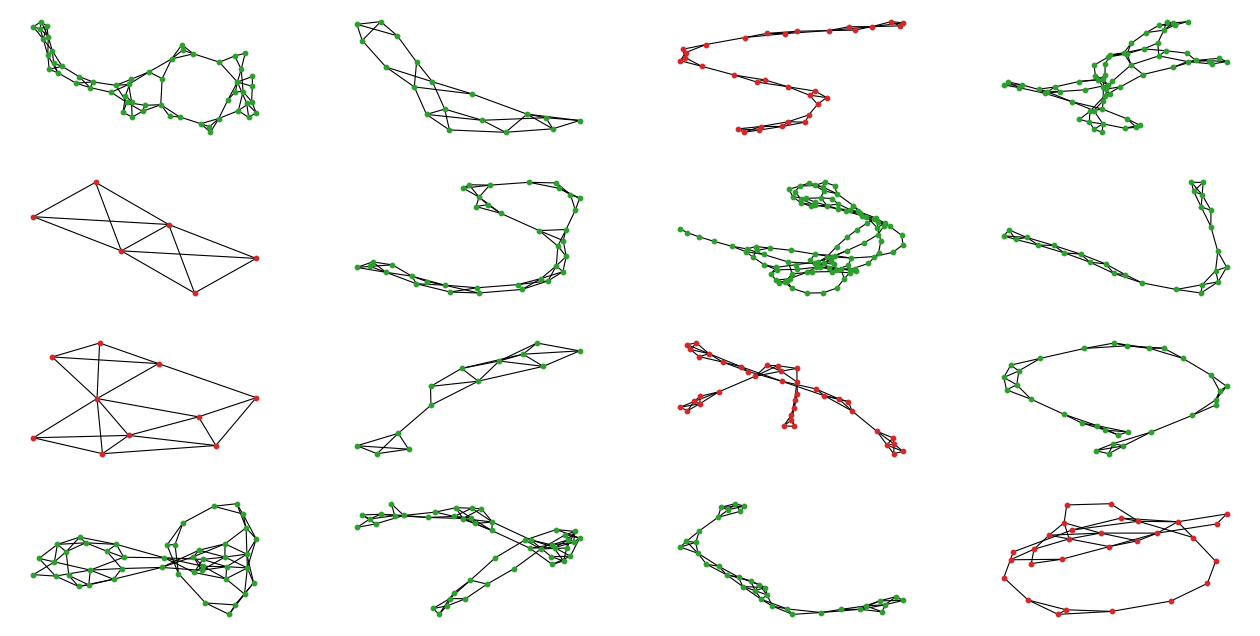

In [54]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4, figsize=(16, 8))

ground_truth = test_dataset[-16:]
predictions = test_pred[-16:]

ax = ax.flatten()
for i, gt in enumerate(ground_truth):
    ax[i].axis('off')

    G = to_networkx(ground_truth[i], to_undirected=True)
    color = "tab:green" if predictions[i] == gt.y else "tab:red"
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=False,
                     node_size=10,
                     node_color=color,
                     width=0.8,
                     ax=ax[i]
                     )


plt.show()
    


## Conclusiones

- La tarea de clasificación de grafos es muy útil para las tareas donde la información pueda ser representada en forma de grafo. El caso de las proteinas es un buen ejemplo ya que estas son en si un grafo.
- Vemos que el modelo a pesar de no ser perfecto, logra clasificar correctamente la mayoría de los ejemplares del conjunto de prueba. Esto es posible gracias a que la arquitectura de la red no solo explota las relaciones de los nodos (aminoacidos) sino que agrega y tiene en cuenta la información del grafo en su totalidad, incluyendo activaciones intermedias de los embeddings.